## Extracting genotype likelihoods and running EBG 

ebg git: https://github.com/pblischak/polyploid-genotyping  

ebg tutorial: https://pblischak.github.io/polyploid-genotyping/

Tiger (genotype error) bitbucket: 
https://bitbucket.org/wegmannlab/tiger/wiki/Home

Tiger paper: https://onlinelibrary.wiley.com/doi/epdf/10.1111/1755-0998.13153  

Workflow thoughts: 

- run Tiger to get sequencing error
- use vcfR to extract read depths
- run EBG in various ways: 
    - Correct way for all individuals 
    - Only *tridentata* and *vayesana* as tetraploid, *wyomingensis* as diploid
    - *wyomingensis* as allotetraploid with af for diploid other subspecies
- Also, generate geno. likelihoods for all as diploid. 
- Also also, refilter variants for *tridentata* and *vayesana* separately and treated as diploid

In [5]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [6]:
analysis_dir = '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/vcf/vcf_part/'

In [7]:
cd $analysis_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/vcf/vcf_part


In [9]:
!mkdir ebg

In [10]:
ebg_dir = os.path.join(analysis_dir, "ebg")
assert os.path.exists(ebg_dir)
ebg_dir

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/vcf/vcf_part/ebg'

In [11]:
cd $ebg_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/vcf/vcf_part/ebg


#### Make sure to move vcf file over and make an unziped copy

In [13]:
vcf_file = os.path.join(ebg_dir, "good_snps.recode.vcf")
assert os.path.exists(vcf_file)
vcf_file

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/vcf/vcf_part/ebg/good_snps.recode.vcf'

In [14]:
vcf_gz_file = os.path.join(ebg_dir, "good_snps.recode.vcf.gz")
assert os.path.exists(vcf_gz_file)
vcf_gz_file

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/vcf/vcf_part/ebg/good_snps.recode.vcf.gz'

## Tiger

./tiger task=estimateHardyWeinberg vcf=simple.vcf.gz groups=simple_sampleGroups.txt

sample groups will be ssp and ploidy (5 total groups)
- file setup: sample name and group (must have header)

In [15]:
!bcftools query -l $vcf_file | sort > sampleGroups.txt 

In [22]:
sample_group = pd.read_csv('sampleGroups.txt',header=None,names=['sample'])

In [23]:
sample_group.head()

,sample
0,AT2_BB_1
1,AT2_BB_10
2,AT2_BB_11
3,AT2_BB_12
4,AT2_BB_13


In [45]:
ssp_ploidy = sample_group['sample'].str.split('_',expand=True)[0]
ssp_ploidy

0      AT2
1      AT2
2      AT2
3      AT2
4      AT2
      ... 
703    AW4
704    AW4
705    AW4
706    AW4
707    AW4
Name: 0, Length: 708, dtype: object

In [47]:
ssp_ploidy_num = ssp_ploidy.replace(ssp_ploidy.unique(),range(1,(len(ssp_ploidy.unique())+1)))

In [48]:
ssp_ploidy_num

0      1
1      1
2      1
3      1
4      1
      ..
703    5
704    5
705    5
706    5
707    5
Name: 0, Length: 708, dtype: int64

In [49]:
sample_group['group'] = ssp_ploidy_num

In [53]:
sample_group.to_csv('sampleGroups.txt',sep='\t',index=False)

### Make slurm file to run tiger

In [55]:
tiger = '/data/gpfs/assoc/parchmanlab/tfaske/src/Tiger/./tiger'

In [75]:
### select options for slurm submission
account = 'cpu-s1-bionres-0'
partition = 'cpu-s1-bionres-0'
#account = 'cpu-s5-denovo-0'
#partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 1 day
cpus = 1
mem_cpu = 60000
email = 'tfaske@nevada.unr.edu'


### because need to edit!!!
vcf_gz_file = 'good_snps.edit.vcf.gz'

In [76]:
def write_tiger_sh(account,partition,time,cpus,mem_cpu,email,tiger,vcf):
    with open("run_tiger.sh", "w") as o:
        o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name tiger
#SBATCH --output output_tiger.txt
#SBATCH --mail-type=FAIL,END
#SBATCH --mail-user=%s \n

module load gcc/9.2.0\n
%s task=estimateHardyWeinberg vcf=%s groups=sampleGroups.txt outname=ARTR.tiger.hwe \n""" % (account,partition,time,int(cpus),int(mem_cpu),email,tiger,vcf))
        

In [77]:
write_tiger_sh(account,partition,time,cpus,mem_cpu,email,tiger,vcf_gz_file)

#### errors 

ERROR: Error when parsing vcf header, unknown tag 'Version' in l
ine '##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Dis
tance Bias for filtering splice-site artefacts in RNA-seq data (
bigger is better)",Version="3">'!

solution: grep -v ',Version="3"' good_snps.recode.vcf > good_snps.edit.vcf; bgzip good_snps.edit.vcf

**count snps**

In [11]:
!zcat $vcf_file | grep -v '#' | wc -l

1303563


### MAF 

try 2% or 14 indv, slowwwww by rest should be faster

In [9]:
!bcftools view -i 'MAF>0.02' $vcf_file -o gatk.ALL.MAF2.vcf.gz -O z

In [10]:
!zcat gatk.ALL.MAF2.vcf.gz | grep -v '#' | wc -l

115996


### missing data

In [20]:
!bcftools view -i 'F_MISSING < 0.5' gatk.ALL.MAF2.vcf.gz -o gatk.ALL.MAF2.miss50.vcf.gz -O z

In [21]:
!zcat gatk.ALL.MAF2.miss50.vcf.gz | grep -v '#' | wc -l

115996


In [22]:
!bcftools view -i 'F_MISSING < 0.4' gatk.ALL.MAF2.vcf.gz -o gatk.ALL.MAF2.miss60.vcf.gz -O z

In [23]:
!zcat gatk.ALL.MAF2.miss60.vcf.gz | grep -v '#' | wc -l

115996


In [34]:
!bcftools view -i 'F_MISSING < 0.3' gatk.ALL.MAF2.vcf.gz -o gatk.ALL.MAF2.miss70.vcf.gz -O z

In [35]:
!zcat gatk.ALL.MAF2.miss70.vcf.gz | grep -v '#' | wc -l

115996


In [26]:
!bcftools view -i 'F_MISSING < 0.2' gatk.ALL.MAF2.vcf.gz -o gatk.ALL.MAF2.miss80.vcf.gz -O z

In [27]:
!zcat gatk.ALL.MAF2.miss80.vcf.gz | grep -v '#' | wc -l

115996


In [28]:
!bcftools view -i 'F_MISSING < 0.1' gatk.ALL.MAF2.vcf.gz -o gatk.ALL.MAF2.miss90.vcf.gz -O z

In [29]:
!zcat gatk.ALL.MAF2.miss90.vcf.gz | grep -v '#' | wc -l

115995


In [32]:
!bcftools view -i 'F_MISSING < 0.05' gatk.ALL.MAF2.vcf.gz -o gatk.ALL.MAF2.miss95.vcf.gz -O z

In [33]:
!zcat gatk.ALL.MAF2.miss95.vcf.gz | grep -v '#' | wc -l

115982


In [40]:
!bcftools view -i 'F_PASS(GT!=".") > 0.5' gatk.ALL.MAF2.vcf.gz -o gatk.ALL.MAF2.miss50.vcf.gz -O z

In [41]:
!zcat gatk.ALL.MAF2.miss50.vcf.gz | grep -v '#' | wc -l

115996


In [42]:
!bcftools view -i 'F_PASS(GT!=".") > 0.9' gatk.ALL.MAF2.vcf.gz -o gatk.ALL.MAF2.miss90.vcf.gz -O z

In [43]:
!zcat gatk.ALL.MAF2.miss90.vcf.gz | grep -v '#' | wc -l

115996


**no missing data??**

### depth and quality

In [44]:
!vcftools --gzvcf gatk.ALL.MAF2.vcf.gz --out gatk.ALL.MAF2.vcf.gz --site-depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf gatk.ALL.MAF2.vcf.gz
	--out gatk.ALL.MAF2.vcf.gz
	--site-depth

Using zlib version: 1.2.11
After filtering, kept 695 out of 695 Individuals
Outputting Depth for Each Site
After filtering, kept 115996 out of a possible 115996 Sites
Run Time = 22.00 seconds


In [45]:
!vcftools --gzvcf gatk.ALL.MAF2.vcf.gz --out gatk.ALL.MAF2.vcf.gz --site-mean-depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf gatk.ALL.MAF2.vcf.gz
	--out gatk.ALL.MAF2.vcf.gz
	--site-mean-depth

Using zlib version: 1.2.11
After filtering, kept 695 out of 695 Individuals
Outputting Depth for Each Site
After filtering, kept 115996 out of a possible 115996 Sites
Run Time = 22.00 seconds


In [46]:
!vcftools --gzvcf gatk.ALL.MAF2.vcf.gz --out gatk.ALL.MAF2.vcf.gz --site-quality


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf gatk.ALL.MAF2.vcf.gz
	--out gatk.ALL.MAF2.vcf.gz
	--site-quality

Using zlib version: 1.2.11
After filtering, kept 695 out of 695 Individuals
Outputting Quality for Each Site
After filtering, kept 115996 out of a possible 115996 Sites
Run Time = 11.00 seconds


In [59]:
depth_df = pd.read_csv('gatk.ALL.MAF2.vcf.gz.ldepth',sep='\t')
depth_mean_df = pd.read_csv('gatk.ALL.MAF2.vcf.gz.ldepth.mean',sep='\t')
qual_df = pd.read_csv('gatk.ALL.MAF2.vcf.gz.lqual',sep='\t')

In [67]:
#loci_df = depth_df.merge(depth_mean_df,qual_df,on=['CHROM','POS'])
loci_df = depth_df.merge(depth_mean_df,on=['CHROM','POS']).merge(qual_df,on=['CHROM','POS'])
loci_df.head()

,CHROM,POS,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,QUAL
0,dDocent_Contig_2499,17,56250,4739602,80.9353,269.444,1619.94
1,dDocent_Contig_2499,31,59727,5392575,85.9381,374.277,3959.45
2,dDocent_Contig_2499,34,59564,5365414,85.7036,375.454,2062.22
3,dDocent_Contig_2499,48,59453,5349041,85.5439,379.251,38450.40
4,dDocent_Contig_2499,64,59232,5310214,85.2259,377.685,40691.00


In [68]:
loci_df.SUM_DEPTH.describe()

count    115996.000000
mean       9427.046562
std       10283.592564
min         222.000000
25%        2773.000000
50%        4955.000000
75%       12005.000000
max      155228.000000
Name: SUM_DEPTH, dtype: float64

In [69]:
loci_df.MEAN_DEPTH.describe()

count    115996.000000
mean         13.564969
std          14.796405
min           0.319424
25%           3.991370
50%           7.130220
75%          17.276300
max         223.350000
Name: MEAN_DEPTH, dtype: float64

In [70]:
loci_df.QUAL.describe()

count    1.159960e+05
mean     2.151644e+04
std      5.505616e+04
min      7.396000e+01
25%      3.650868e+03
50%      7.230650e+03
75%      1.820407e+04
max      2.579280e+06
Name: QUAL, dtype: float64

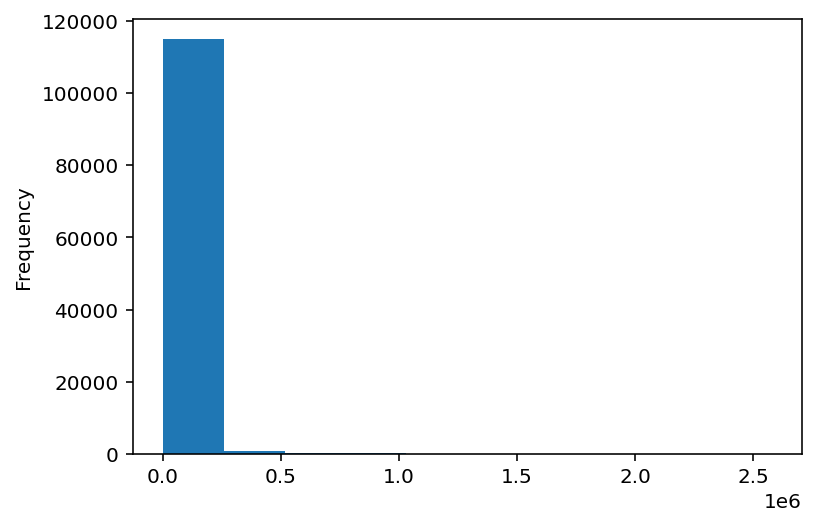

In [71]:
loci_df.QUAL.plot(kind="hist");

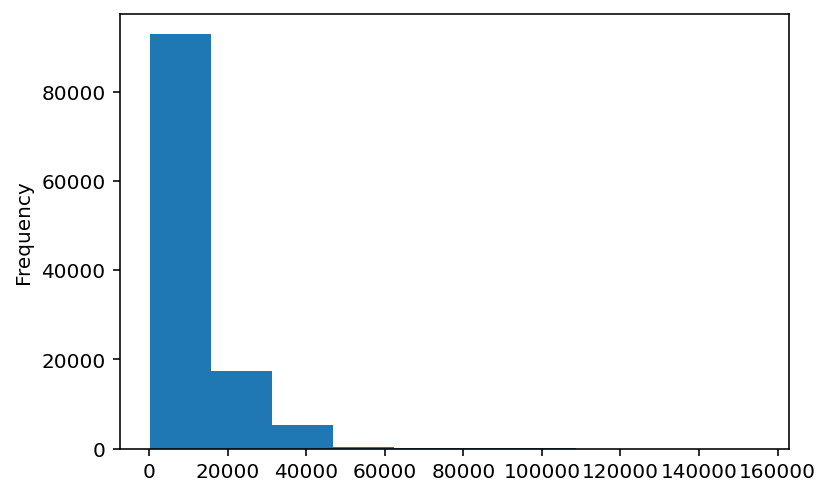

In [72]:
loci_df.SUM_DEPTH.plot(kind="hist");

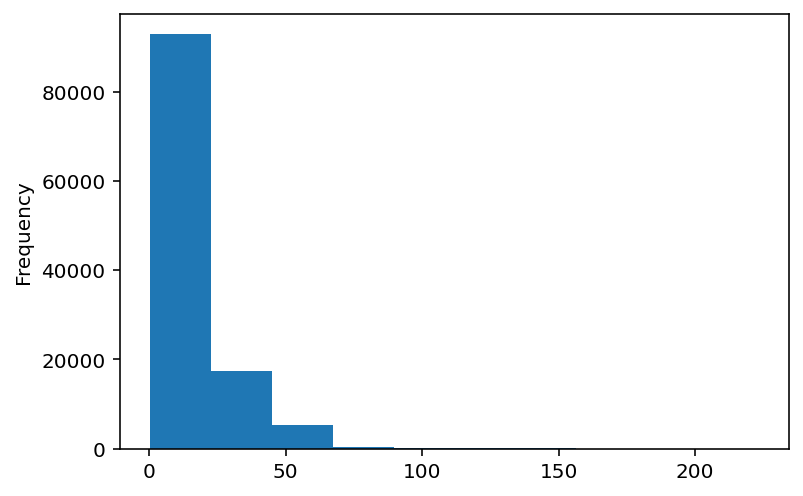

In [73]:
loci_df.MEAN_DEPTH.plot(kind="hist");

In [74]:
len(loci_df[loci_df.SUM_DEPTH <15000]),len(loci_df[loci_df.SUM_DEPTH >=1000])

(91821, 113890)

In [81]:
len(loci_df[loci_df.MEAN_DEPTH <20]),len(loci_df[loci_df.MEAN_DEPTH >=2])

(90219, 110811)

In [82]:
len(loci_df[loci_df.QUAL <  200]), len(loci_df[loci_df.QUAL < 500]), len(loci_df[loci_df.QUAL < 999])

(68, 623, 1828)

#### DO NOT remove based off Fis

In [83]:
def filter_snps(df, imputed=False):
    if imputed:
        return df[(df.MAF >= 0.01) &  
                  (df.Fis > -0.5)]
    else:
        return df[(df.MEAN_DEPTH >= 2) & 
                  (df.MEAN_DEPTH < 20) & 
                  (df.QUAL >= 999)]

In [84]:
loci_stage1 = filter_snps(loci_df)
loci_stage1.shape

(83881, 7)

In [91]:
with open(os.path.join(analysis_dir, "stage1_positions.txt"), "w") as o:
    for i in range(0,len(loci_stage1)):
        c = loci_stage1.CHROM.iloc[i]
        p = loci_stage1.POS.iloc[i]
        o.write("%s\t%s\n" % (c,p))

In [98]:
!bcftools view -T stage1_positions.txt gatk.ALL.MAF2.vcf.gz > gatk.ALL.stage1.vcf

In [99]:
!grep -v '#' gatk.ALL.stage1.vcf | wc -l

83826


## thin to 1 per contig

In [100]:
loci_stage1.head()

,CHROM,POS,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,QUAL
173,dDocent_Contig_33205,21,12687,365139,18.2547,192.4240,2766.14
174,dDocent_Contig_33205,26,12673,364117,18.2345,191.6870,2388.45
184,dDocent_Contig_45538,49,8925,160923,12.8417,66.7300,123744.00
191,dDocent_Contig_47372,37,8091,127205,11.6417,47.5674,5776.69
192,dDocent_Contig_47372,47,8055,125991,11.5899,47.0232,2902.26


In [102]:
len(loci_stage1.CHROM.unique())

35486

In [108]:
loci_stage1.groupby(['CHROM'])['MEAN_DEPTH'].idxmax()

CHROM
dDocent_Contig_100010     34356
dDocent_Contig_100043     22606
dDocent_Contig_100047    107764
dDocent_Contig_100074     23801
dDocent_Contig_100083     47067
                          ...  
dDocent_Contig_99937      33107
dDocent_Contig_99965      67050
dDocent_Contig_99971      85831
dDocent_Contig_99987       8723
dDocent_Contig_99992     106486
Name: MEAN_DEPTH, Length: 35486, dtype: int64

In [109]:
#loci_stage2 = loci_stage1.groupby(['CHROM'])['MEAN_DEPTH'].agg('max')
loci_stage2 = loci_stage1.loc[loci_stage1.groupby(['CHROM'])['MEAN_DEPTH'].idxmax()]

loci_stage2.shape

(35486, 7)

In [110]:
loci_stage2.head()

,CHROM,POS,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,QUAL
34356,dDocent_Contig_100010,73,5470,100316,7.87050,82.5135,3678.71
22606,dDocent_Contig_100043,82,4241,38045,6.10216,17.5299,64906.00
107764,dDocent_Contig_100047,76,7170,105038,10.31650,44.7671,5983.41
23801,dDocent_Contig_100074,41,7450,107564,10.71940,39.9197,17096.80
47067,dDocent_Contig_100083,63,3359,57117,4.83309,58.9087,4488.03


In [112]:
with open(os.path.join(analysis_dir, "stage2_positions.txt"), "w") as o:
    for i in range(0,len(loci_stage2)):
        c = loci_stage2.CHROM.iloc[i]
        p = loci_stage2.POS.iloc[i]
        o.write("%s\t%s\n" % (c,p))

In [113]:
!bcftools view -T stage2_positions.txt gatk.ALL.stage1.vcf > gatk.ALL.stage2.vcf

In [114]:
!grep -v '#' gatk.ALL.stage2.vcf | wc -l

35311


In [115]:
snps = os.path.join(analysis_dir, "gatk.ALL.stage2.vcf")
snps_gz = os.path.join(analysis_dir, "gatk.ALL.final.vcf") + ".gz"
!$bgzip -c {snps} > {snps_gz}
!$tabix {snps_gz}

## 012 

though doesnt work for polyploid, gets ID file 

In [119]:
f = os.path.join(analysis_dir, "gatk.ALL.final.vcf.gz")
!$vcftools --gzvcf {f} \
--out {f} \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/gatk/filtering/gatk.ALL.final.vcf.gz
	--012
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/gatk/filtering/gatk.ALL.final.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 695 out of 695 Individuals
Writing 012 matrix files ... Error: Polyploidy found, and not supported by vcftools: dDocent_Contig_33205:21


# Get coverage per individual

In [116]:
f = os.path.join(analysis_dir, "gatk.ALL.final.vcf.gz")
!$vcftools --gzvcf {f} \
--out {f} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/gatk/filtering/gatk.ALL.final.vcf.gz
	--depth
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/gatk/filtering/gatk.ALL.final.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 695 out of 695 Individuals
Outputting Mean Depth by Individual
After filtering, kept 35311 out of a possible 35311 Sites
Run Time = 7.00 seconds


In [117]:
depth_file = os.path.join(analysis_dir, "gatk.ALL.final.vcf.gz.idepth")
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,AT2_BB_1,35309,7.49398
1,AT2_BB_10,35309,7.96279
2,AT2_BB_11,35309,5.80181
3,AT2_BB_12,35309,4.75049
4,AT2_BB_13,35309,6.93446


In [118]:
depth_df.MEAN_DEPTH.describe()

count    695.000000
mean       7.208436
std        2.473142
min        0.150435
25%        5.434870
50%        6.855250
75%        8.887000
max       14.940900
Name: MEAN_DEPTH, dtype: float64

# Remove unnecessary files

In [62]:
!rm snps*

In [63]:
!rm fb*

In [64]:
!rm *vcf